<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Text-classification-Sentiment-Analysis/blob/main/Sentiment_Analysis_with_Simple_RNN%2C_LSTM%2C_GRU_and_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Simple RNN, LSTM, GRU Conv1D & Transfer learning (Pretrained Word2Vec[Gensim])

## Imports

In [2]:
!pip install -q --upgrade keras tensorflow

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense, Flatten, SimpleRNN, Conv1D, InputLayer, Bidirectional, GRU, LSTM, BatchNormalization, Dropout, Input, Embedding, TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

from google.colab import files
from google.colab import drive
from tensorboard.plugins import projector

## Define Hyperparameters

In [4]:
BATCH_SIZE = 64

## Download IMDB Dataset

In [5]:
## Load IMDB Dataset from TF Hub
train_ds, val_ds, test_ds = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'train[80%:90%]', 'train[90%:]'),
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.JU1N7P_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.JU1N7P_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.JU1N7P_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [6]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
# Let's print few samples from the dataset
for text, label in train_ds.take(5):
  print(f'text:', text.numpy())
  print(f'label:',  label.numpy())

text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label: 0
text: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The

## Data Preparation

In [8]:
## Standardization [Input: raw reviews | Output: standardized reviews]
def standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<[^>]+>', '')
  output = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
  return output

In [9]:
standardization(tf.constant('This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'))

<tf.Tensor: shape=(), dtype=string, numpy=b'this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big armchair and mellow for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no rapids to cross no dangerous waters just a warm and witty paddle through new york life at its best a family film in every sense and one that deserves the praise it received'>

In [10]:
## Vectorization
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 300

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

training_data = train_ds.map(lambda x, y: x)  # Input: x, y and Output: x
vectorize_layer.adapt(training_data)

In [11]:
len(vectorize_layer.get_vocabulary())

10000

In [12]:
vectorize_layer.get_vocabulary()[123]

'better'

In [13]:
def vectorizer(review, label):
  return vectorize_layer(review), label

In [14]:
train_dataset = train_ds.map(vectorizer)
val_dataset = val_ds.map(vectorizer)

In [15]:
vectorize_layer.get_vocabulary()[123]

'better'

In [16]:
for review, label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  410  375   17   89   26 9998    8   32 1338 4103   40
  506    1  192   23   84  149   18   10  215  316   26   64  239  212
    8  480   55   64   84  114   94   21 5600   10   92  626  736   10
   17    7   33  396 9977  167 2453  406    2   87 1192  133   66  142
   52    2    1 6960   66  244   64 2902   15    1 2792    1    1 1429
 4989    3   39    1 1645   16 4103   13  155   18    4 1192  846 7659
    8    4   17   12   13 3832    5   97  145 1215   11  230  673   12
   48   23   92   37   10 7505  149   37 1338    1   49  407   11   94
 1149  838  139    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [17]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [57]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Build the Simple RNN Model
![](https://www.researchgate.net/publication/349025949/figure/fig5/AS:987328210284547@1612408797977/A-simple-RNN-architecture-unrolling.ppm)

In [ ]:
inputs = np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn = tf.keras.layers.SimpleRNN(4)
output = simple_rnn(inputs)
print(output.shape)

(32, 4)


In [ ]:
EMBEDDING_DIM = 64
VOCAB_SIZE = 10000

model = tf.keras.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/simple_rnn_model.keras' # Change the file extension to '.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.4925 - loss: 0.6933 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.4920 - loss: 0.6933 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.4917 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.4916 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.4906 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 110ms/step - accuracy: 0.4906 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.4900 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.4900 - loss: 0.6

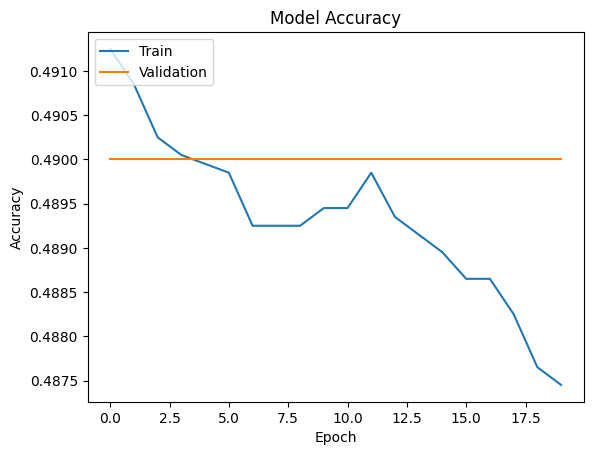

In [ ]:
# Plot model accuracy results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

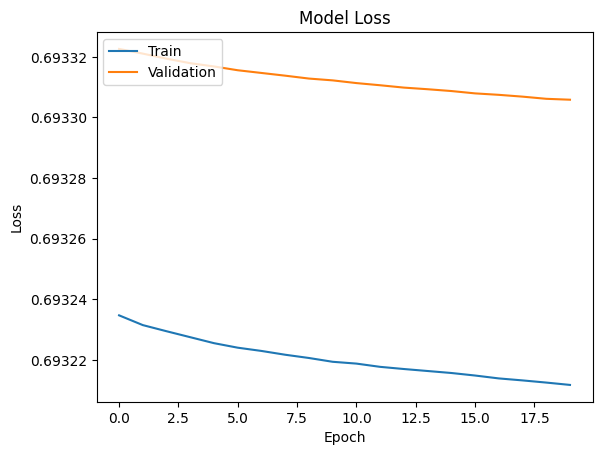

In [ ]:
# Plot model losses results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
## Evaluating on test dataset
test_dataset = test_ds.map(vectorizer)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
model.evaluate(test_dataset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5154 - loss: 0.6930


[0.6932028532028198, 0.4975999891757965]

## Build LSTM (Multilayer and Bidirectional)

![](https://miro.medium.com/v2/resize:fit:680/1*sf4vCzcyycSe7GC3dZ2u2w.png)

In [ ]:
EMBEDDING_DIM = 64
VOCAB_SIZE = 10000

model = tf.keras.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 250, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/lstm_model.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 248s 792ms/step - accuracy: 0.4957 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 253s 809ms/step - accuracy: 0.5053 - loss: 0.6930 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 234s 748ms/step - accuracy: 0.5002 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 281s 900ms/step - accuracy: 0.4932 - loss: 0.6933 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 226s 722ms/step - accuracy: 0.5040 - loss: 0.6931 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 215s 687ms/step - accuracy: 0.4951 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 212s 676ms/step - accuracy: 0.5038 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 213s 680ms/step - accuracy: 0.4965 -

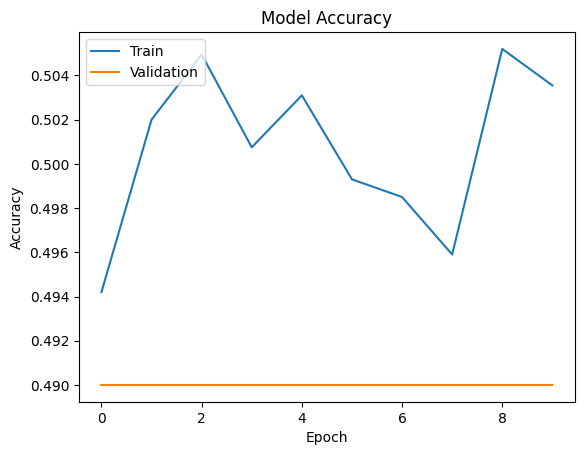

In [ ]:
# Plot accuracy results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

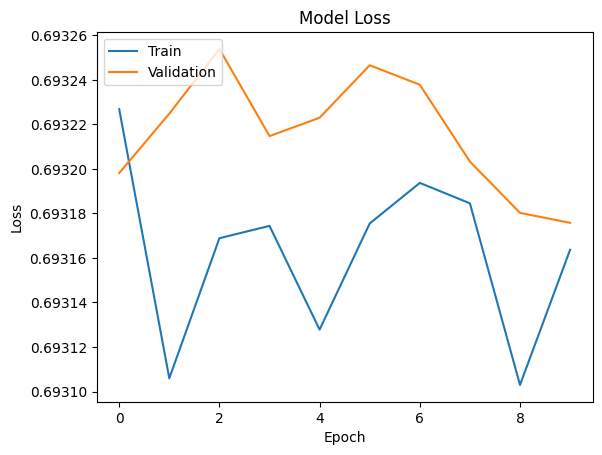

In [ ]:
# Plot loss results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluating on test dataset
test_dataset = test_ds.map(vectorizer)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
model.evaluate(test_dataset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.5154 - loss: 0.6931


[0.6931547522544861, 0.4975999891757965]

## Build GRU (Multilayer and Bidirectional)

![](https://www.researchgate.net/publication/368401217/figure/fig3/AS:11431281179417554@1691186189285/GRU-model-structureGRU-gated-recurrent-neural-network.png)

In [ ]:
EMBEDDING_DIM = 64
VOCAB_SIZE = 10000

model = tf.keras.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 250, 128)            │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 725,249 (2.77 MB)

 Trainable params: 725,249 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/gru_model.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    )

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 302s 789ms/step - accuracy: 0.4951 - loss: 0.6933 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 244s 779ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 266s 791ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 268s 813ms/step - accuracy: 0.4949 - loss: 0.6933 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 289s 902ms/step - accuracy: 0.4950 - loss: 0.6933 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 273s 873ms/step - accuracy: 0.5032 - loss: 0.6931 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 342s 938ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 299s 864ms/step - accuracy: 0.4913 -

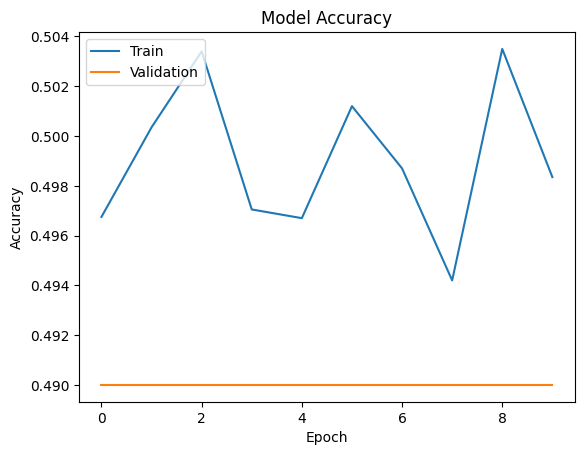

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

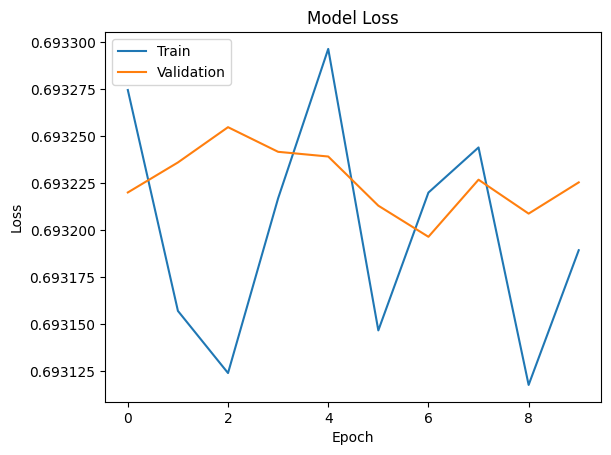

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate on Test Dataset
test_dataset = test_ds.map(vectorizer)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
model.evaluate(test_dataset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.5154 - loss: 0.6930


[0.6931708455085754, 0.4975999891757965]

## Build the Conv1D Model

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Parameters
EMBEDDING_DIM = 300
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250

model = tf.keras.models.Sequential([
    Input(shape=(250,)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    Conv1D(32, 3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 248, 32)             │          28,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,029,921 (11.56 MB)

 Trainable params: 3,029,921 (11.56 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
checkpoint_filepath = '/content/drive/MyDrive/conv1d_model.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [20]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 213ms/step - accuracy: 0.4979 - loss: 0.6963 - val_accuracy: 0.5104 - val_loss: 0.6922
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - accuracy: 0.5044 - loss: 0.6948 - val_accuracy: 0.5120 - val_loss: 0.6909
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 170ms/step - accuracy: 0.5203 - loss: 0.6923 - val_accuracy: 0.5452 - val_loss: 0.6894
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 174ms/step - accuracy: 0.5364 - loss: 0.6893 - val_accuracy: 0.6052 - val_loss: 0.6870
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 178ms/step - accuracy: 0.5559 - loss: 0.6864 - val_accuracy: 0.6684 - val_loss: 0.6838
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.5775 - loss: 0.6828 - val_accuracy: 0.6872 - val_loss: 0.6803
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - accuracy: 0.6016 - loss: 0.6775 - val_accuracy: 0.7032 - val_loss: 0.6763
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 199ms/step - accuracy: 0.6166 - loss: 0

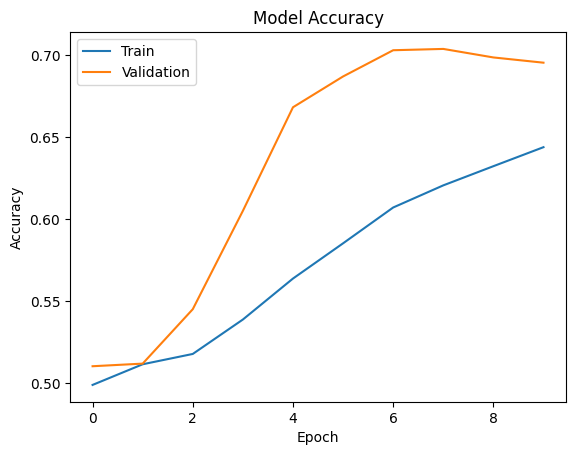

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

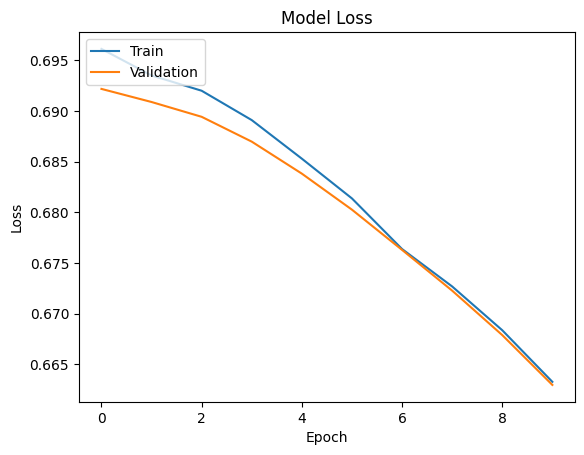

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
model.load_weights(checkpoint_filepath)

test_dataset = test_ds.map(vectorizer)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
model.evaluate(test_dataset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7135 - loss: 0.6718


[0.6717967987060547, 0.7131999731063843]

## Transfer Learning with Pretrained Word2Vec [Gensim]

In [ ]:
work2vec_model = api.load('word2vec-google-news-300')

In [30]:
work2vec_model.vectors.shape

(3000000, 300)

In [33]:
len(work2vec_model['The'])

300

In [34]:
work2vec_model.most_similar('good')

[('great', 0.7291510105133057),
 ('bad', 0.7190051078796387),
 ('terrific', 0.6889115571975708),
 ('decent', 0.6837348341941833),
 ('nice', 0.6836092472076416),
 ('excellent', 0.644292950630188),
 ('fantastic', 0.6407778263092041),
 ('better', 0.6120728850364685),
 ('solid', 0.5806034803390503),
 ('lousy', 0.576420247554779)]

In [36]:
word2vec = work2vec_model

In [37]:
def first_caps(word):
    return word.capitalize()

pretrained_embeddings = []

for i, word in enumerate(vectorize_layer.get_vocabulary()):
    try:
        # Try to get the embedding directly
        embedding = word2vec[word]
    except KeyError:
        print(f"Word not found in pretrained embeddings: {word}")
        try:
            # Try to get the embedding with first letter capitalized
            embedding = word2vec[first_caps(word)]
            print(f"Found by capitalizing: {first_caps(word)}")
        except KeyError:
            # If still not found, use a random embedding
            print(f"No solution found for word: {word}")
            embedding = np.random.normal(loc=0, scale=1, size=(EMBEDDING_DIM,))

    pretrained_embeddings.append(embedding)

    if i % 1000 == 0:
        print(f"Processed {i} words out of {len(vectorize_layer.get_vocabulary())}")

print("Finished processing all words.")


Word not found in pretrained embeddings: 
No solution found for word: 
Processed 0 words out of 10000
Word not found in pretrained embeddings: [UNK]
No solution found for word: [UNK]
Word not found in pretrained embeddings: and
Found by capitalizing: And
Word not found in pretrained embeddings: a
Found by capitalizing: A
Word not found in pretrained embeddings: of
Found by capitalizing: Of
Word not found in pretrained embeddings: to
Found by capitalizing: To
Word not found in pretrained embeddings: doesnt
No solution found for word: doesnt
Word not found in pretrained embeddings: didnt
No solution found for word: didnt
Word not found in pretrained embeddings: isnt
No solution found for word: isnt
Word not found in pretrained embeddings: wasnt
No solution found for word: wasnt
Word not found in pretrained embeddings: 10
No solution found for word: 10
Word not found in pretrained embeddings: 80s
No solution found for word: 80s
Word not found in pretrained embeddings: 20
No solution found

In [38]:
pretrained_embeddings_array = np.array(pretrained_embeddings)
pretrained_embeddings_array.shape

(10000, 300)

In [45]:
EMBEDDING_DIM = 300
VOCAB_SIZE = 10000

model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu'),
    # Flatten(),
    tf.keras.layers.GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 248, 32)             │          28,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,029,921 (11.56 MB)

 Trainable params: 3,029,921 (11.56 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
checkpoint_filepath = '/content/drive/MyDrive/transfer_learning_model.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [47]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

In [48]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 270ms/step - accuracy: 0.4963 - loss: 0.8474 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 215ms/step - accuracy: 0.5084 - loss: 0.7570 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 205ms/step - accuracy: 0.5013 - loss: 0.7391 - val_accuracy: 0.5448 - val_loss: 0.6889
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 237ms/step - accuracy: 0.5096 - loss: 0.7217 - val_accuracy: 0.5404 - val_loss: 0.6878
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 257ms/step - accuracy: 0.5152 - loss: 0.7132 - val_accuracy: 0.5532 - val_loss: 0.6855
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 67s 209ms/step - accuracy: 0.5176 - loss: 0.7078 - val_accuracy: 0.5564 - val_loss: 0.6853
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - accuracy: 0.5258 - loss: 0.6975 - val_accuracy: 0.5632 - val_loss: 0.6831
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.5304 - loss: 

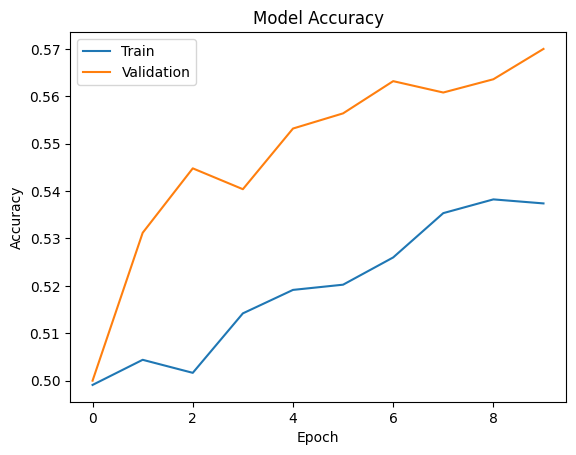

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

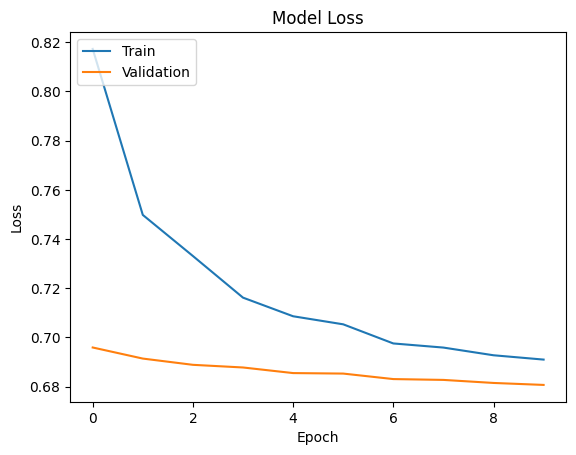

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
# Evaluate on test data
model.load_weights(checkpoint_filepath)

test_dataset = test_ds.map(vectorizer)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
model.evaluate(test_dataset)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5757 - loss: 0.6789


[0.6801663041114807, 0.5812000036239624]

## Testing

In [53]:
# test_pos="this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "
# test_neg="very good start, but movie started becoming boring at some point and unfortunately i didn't feel like this was properly produced as there was too much background noise, and the actors didn't look motivated at all "

test_data = tf.data.Dataset.from_tensor_slices([
    ["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
    ["very good start, but movie started becoming boring at some point and unfortunately i didn't feel like this was properly produced as there was too much background noise, and the actors didn't look motivated at all "]
])

def vectorizer_test(review):
  return vectorize_layer(review)

test_dataset = test_data.map(vectorizer_test)

model.predict(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


array([[0.5255348],
       [0.4667781]], dtype=float32)